## Lecture 10: Structural equation modeling

In this lecture we will focus on the estimation of parameters for SEM models.  We will use the *lavaan* R package for SEM analysis - there are Python-based packages, but they are not as widely accepted as lavaan. This will also highlight the utility of the R-to-Python bridge provided by Jupyter and the rpy2 package.

In [6]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from IPython.display import display, HTML
import rpy2
import matplotlib.pyplot as plt
import rpy2.robjects as robjects
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.packages import importr
pandas2ri.activate()

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Linear regression

We will start by showing how one can estimate a multiple linear regression model using SEM.  We will use simulated data so that we know the ground truth.

First, let's generate some data.

In [7]:
npts = 500
noise_sd = 5
np.random.seed(12345)
cov = np.eye(3)
cov[1, 2], cov[2, 1] = [0.5, 0.5]
cov[0, 1], cov[1, 0] = [0.2, 0.2]
simdata = np.random.multivariate_normal([0, 0, 0], cov, npts)
simdataDf = pd.DataFrame({'a': simdata[:, 0],
                         'b': simdata[:, 1],
                         'c': simdata[:, 2]})
beta = np.array([0.5, 1, 0])
simdataDf['Y'] = simdataDf.dot(beta) + np.random.randn(npts)*noise_sd

simdataDf.corr()

,a,b,c,Y
a,1.000000,0.171108,-0.053131,0.207839
b,0.171108,1.000000,0.490903,0.215741
c,-0.053131,0.490903,1.000000,0.047786
Y,0.207839,0.215741,0.047786,1.000000


In [8]:
# estimate linear regression model

X = sm.add_constant(simdataDf[['a', 'b', 'c']])
y = simdataDf['Y']
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     14.03
Date:                Fri, 24 Apr 2020   Prob (F-statistic):           8.64e-09
Time:                        13:29:14   Log-Likelihood:                -1526.7
No. Observations:                 500   AIC:                             3061.
Df Residuals:                     496   BIC:                             3078.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3060      0.231      1.327      0.1

Now let's build a structural model for this analysis using lavaan.

In [51]:
%%R -i simdataDf -o results

library(lavaan)
myModel <- ' # regressions
             Y ~ a + b + c
    
             # variances and covariances 
             Y ~~ Y 

             # intercepts 
             Y~ 1 
           '

fit <- lavaan(myModel, data=simdataDf)
summary(fit, standardized=TRUE)

results = list(fitted = fitted(fit)$cov,
              resid = resid(fit)$cov,
              coefs = coef(fit))

lavaan 0.6-5 ended normally after 31 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of free parameters                          5
                                                      
  Number of observations                           500
                                                      
Model Test User Model:
                                                      
  Test statistic                                 0.000
  Degrees of freedom                                 0

Parameter Estimates:

  Information                                 Expected
  Information saturated (h1) model          Structured
  Standard errors                             Standard

Regressions:
                   Estimate  Std.Err  z-value  P(>|z|)   Std.lv  Std.all
  Y ~                                                                   
    a                 0.929    0.242    3.841    0.000    0.929    0.170
    b       

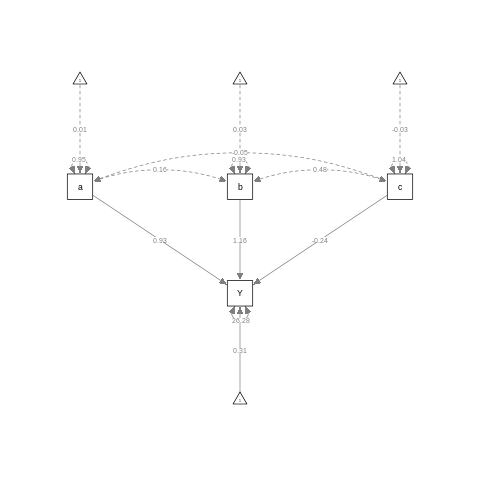

In [52]:
%%R
library(semPlot)

semPaths(fit, "model", "est")

As you can see, the estimated parameters from SEM are the same as the regression model. However, the standard errors are very slightly different - this is because the OLS regression estimates using the unbiased estimator for the variance (with N-1 in the denominator), whereas SEM uses maximum likelihood which is a biased estimator of the variance (with N in the denominator).  These differences are minor unless the sample size is very small.



## Estimating SEM parameters

We saw in the earlier session on regression how those parameters are estimated using least squares.  SEM models are estimated in a different way.  Most importantly, the main difference between SEM and regression is the loss function: Whereas in linear regression we used the sum of squared errors between the predicted and estimated values for the data points, in SEM we use the sum of squared differences between the observed covariance and the covariance predicted by the model. For this reason, these models are often referred to as "covariance structure models".

The observed covariance between all measured variables serves as our estimate of the population covariance, which we simply plug into the loss function.  We compare this to the covariance matrix that is implied by any specific set of parameter values. 

Let's see how this works for the simple regression example, where we only have a single parameter.  The implied covariance matrix here is:



| $\sigma^2(a)$  |                | 
| ------------- | -------------  |
| $cov(x*\beta_1,y)$    |  $\sigma^2(y)$  |  


This only differs from the observed covariance matrix at one location (since the variances of x and y remain the same), which is the covariance of predicted values (using $\beta_1$) with the observed values.

Now that we have seen how to compute the implied covariance matrix for a particular set of parameters, we can compute the loss function that is used for maximum likelihood estimation:

$$
F_{ML}(\theta) = log |\Sigma| + tr(\textbf{S}\Sigma^{-1}) - log|\textbf{S}| - (p + q)
$$

where p is the number of endogenous (dependent) variables, and q is the number of exogenous (independent) variables.

In [ ]:
sigma = np.array([np.std(x)])

| This | is   |
|------|------|
|   a  | table|

For this example, let's use a slightly more complex model, where we have a causal chain relating two variables (after Bollen, 1989, p. 88):

$$
y_1 = \gamma_{11}*x_1 + \xi_1
$$

$$
y_2 = \beta_{21}*y_1 + \xi_2
$$

where $x$ is an independent variable, $y_1$ and $y_2$ are dependent variables, and $\xi_1$ and $\xi_2$ are *disturbances* (i.e. error variables).

In [11]:
noise_sd = [4, 6]
chainDf = pd.DataFrame({'x': np.random.randn(npts)})
chainDf['y1'] = chainDf.x * 1.5 + np.random.randn(npts)*noise_sd[0]
chainDf['y2'] = chainDf['y1'] * 3 + np.random.randn(npts)*noise_sd[1]
chainDf = chainDf[['y1', 'y2', 'x']]
chainDf.cov()

,y1,y2,x
y1,18.778761,56.522409,1.612106
y2,56.522409,206.186173,5.383139
x,1.612106,5.383139,0.997718


In [12]:
%%R -i chainDf -o results

library(lavaan)
myModel <- ' # regressions
             y1 ~ x
             y2 ~ y1
    
             # variances and covariances 
             y1 ~~ y1
             y2 ~~ y2

             # intercepts 
             y1 ~ 1 
             y2 ~ 1
           '

fit <- lavaan(myModel, data=chainDf)
summary(fit, standardized=TRUE)

results = list(fitted = fitted(fit)$cov,
              resid = resid(fit)$cov,
              coefs = coef(fit))

lavaan 0.6-5 ended normally after 35 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of free parameters                          6
                                                      
  Number of observations                           500
                                                      
Model Test User Model:
                                                      
  Test statistic                                 4.568
  Degrees of freedom                                 1
  P-value (Chi-square)                           0.033

Parameter Estimates:

  Information                                 Expected
  Information saturated (h1) model          Structured
  Standard errors                             Standard

Regressions:
                   Estimate  Std.Err  z-value  P(>|z|)   Std.lv  Std.all
  y1 ~                                                                  
    x                 1.616   

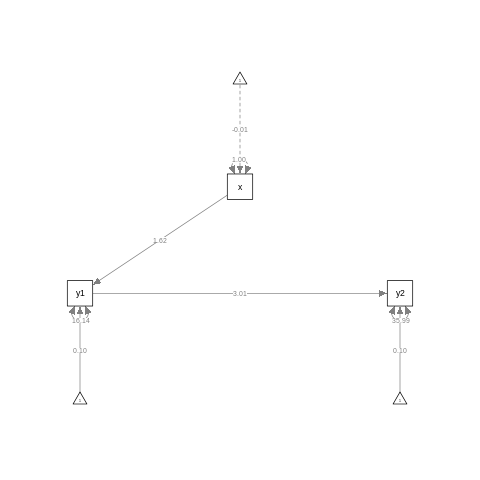

In [13]:
%%R

semPaths(fit, "model", "est")

In [14]:
implied, resid, coefs = np.array(results[0]), np.array(results[1]), np.array(results[2])
cov = resid + implied
cov

array([[ 18.74120332,  56.40936467,   1.60888187],
       [ 56.40936467, 205.77380104,   5.3723729 ],
       [  1.60888187,   5.3723729 ,   0.99572298]])

In [15]:
cov_est = np.cov(chainDf.T, bias=True)
cov_est
assert np.allclose(cov, cov_est)

In [16]:
print(results[2])

[ 1.61579264  3.00991157 16.14158384 35.98660184  0.09997267  0.10359135]


In [17]:
implied

array([[ 18.74120331,  56.40936463,   1.60888186],
       [ 56.40936463, 205.77380097,   4.84259212],
       [  1.60888186,   4.84259212,   0.99572298]])

In [18]:
# add Bollen's eq 4.15

In [19]:
# reconstruct the implied covariance matrix from the estimated parameters
def get_implied_cov(coefs, cov_est):
    my_implied = np.zeros(implied.shape)
    my_implied[0,0] = (coefs[0]**2) * cov_est[2,2] + coefs[2]
    my_implied[1, 0] = coefs[1]*(my_implied[0, 0])
    my_implied[2, 0] = coefs[0]*cov_est[2, 2]
    my_implied[1, 1] = (coefs[1]**2)*my_implied[0, 0] + coefs[3]
    my_implied[2, 1] = coefs[1]*coefs[0]*cov_est[2, 2]
    my_implied[2,2] = cov_est[2,2]

    my_implied[np.triu_indices_from(my_implied, 1)] = my_implied[np.tril_indices_from(my_implied, -1)]
    return(my_implied)

my_implied = get_implied_cov(coefs, cov_est)
assert np.allclose(my_implied, implied)

## Computing the loss

Now that we have seen how to compute the implied covariance matrix for a particular set of parameters, we can compute the loss function that is used for maximum likelihood estimation:

$$
F_{ML}(\theta) = log |\Sigma| + tr(\textbf{S}\Sigma^{-1}) - log|\textbf{S}| - (p + q)
$$

where p is the number of endogenous (dependent) variables, and q is the number of exogenous (independent) variables.


In [20]:
def f_ml(cov_est, implied, verbose=True):
    log_det_implied = np.log(np.linalg.det(implied) )
    if verbose:
        print(log_det_implied)
    cov_ratio_trace = np.trace(np.linalg.inv(cov_est).dot(implied))
    if verbose:
        print(cov_ratio_trace)
    log_det_observed = np.log(np.linalg.det(cov_est))
    if verbose:
        print(log_det_observed)
    F_ml = log_det_implied + np.trace(np.linalg.inv(cov_est).dot(implied)) - log_det_observed - cov_est.shape[0]
    return(F_ml)
  

In [21]:
f_ml(cov_est, implied)

6.3602592946689
3.0183553197351753
6.351123493497318


0.027491120906756983

Let's try some various parameter values and look at the likelihood landscape:

In [22]:
y1xvals = np.arange(1, 1.12, .001)
y2y1vals = np.arange(2.98, 3.03, .001)

ml_est = np.zeros((y1xvals.shape[0], y2y1vals.shape[0]))
for i, p0 in enumerate(y1xvals):
    for j, p1 in enumerate(y2y1vals):
        sim_coefs = coefs.copy()
        sim_coefs[0] = p0
        sim_coefs[1] = p1
        sim_implied = get_implied_cov(sim_coefs, cov_est)
        ml_est[i, j] = f_ml(cov_est, sim_implied, verbose=False)



In [23]:
minloc = np.where(ml_est == np.min(ml_est))
print(y1xvals[minloc[0]])
print(y2y1vals[minloc[1]])

[1.12]
[2.996]


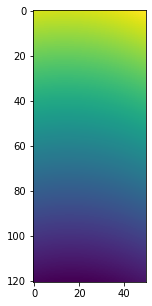

In [24]:
fig = plt.figure(figsize=(10, 5))
plt.imshow(ml_est)


## Identification of SEMs



## Confirmatory factor analysis

One common use of structural equation modeling is for the estimation of *confirmatory factor analysis* models.  These models include a set of *indicator* variables, which reflect observed measurements.  Each indicator in a standard CFA model has two latent inputs: a single *factor* which is measured by that indicator, and an *error* term that represents the unique sources of variance for that indicator.  There can be multiple factors, which are allowed to correlate with one another.  

For standard CFA models (in which each observed variable is associated with a single latent factor), the identification requirements are simple: for a single factor there must be three indicators, and for two or more factors each factor must be associated with at least two indicators.

As an example, we will use the SRO dataset to fit a CFA model with three factors:

Impulsivity: measured by BIS-11 (nonplanning), Dickman (dysfunctional), and impulsive venturesomeness (impulsiveness) scores
Sensation seeking: measured by UPPS-P (sensation seeking), sensation seeking survey (thrill seeking), and BIS-BAS (fun seeking) scores
Goal-directedness: measured by Grit scale (grit), TIPS (conscientiousness), and UPPS-P (lack of perseverance) scores

Let's set up the model in lavaan:


In [25]:
from data_utils import get_SRO_data
SRO_data = get_SRO_data()
cfadata = SRO_data[['bis11_survey.Nonplanning',
                    'dickman_survey.dysfunctional',
                    'impulsive_venture_survey.impulsiveness',
                    'bis_bas_survey.BAS_fun_seeking',
                    'sensation_seeking_survey.thrill_adventure_seeking',
                    'upps_impulsivity_survey.sensation_seeking',
                    'upps_impulsivity_survey.lack_of_perseverance',
                    'ten_item_personality_survey.conscientiousness',
                    'grit_scale_survey.grit']].dropna()

In [26]:
%%R -i cfadata

cfa.model <- 'IMP =~ bis11_survey.Nonplanning + dickman_survey.dysfunctional + impulsive_venture_survey.impulsiveness
              SS =~ bis_bas_survey.BAS_fun_seeking + sensation_seeking_survey.thrill_adventure_seeking + upps_impulsivity_survey.sensation_seeking
              GD =~ upps_impulsivity_survey.lack_of_perseverance + ten_item_personality_survey.conscientiousness + grit_scale_survey.grit'

fit <- cfa(cfa.model, data=cfadata)

summary(fit)

lavaan 0.6-5 ended normally after 51 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of free parameters                         21
                                                      
  Number of observations                           510
                                                      
Model Test User Model:
                                                      
  Test statistic                               348.645
  Degrees of freedom                                24
  P-value (Chi-square)                           0.000

Parameter Estimates:

  Information                                 Expected
  Information saturated (h1) model          Structured
  Standard errors                             Standard

Latent Variables:
                   Estimate  Std.Err  z-value  P(>|z|)
  IMP =~                                              
    bs11_srvy.Nnpl    1.000                           
    dc

In [44]:
%%R
s = semPlotModel(fit)
modelMatrices(s)



$A
$A[[1]]
$A[[1]]$est
                                                  bis11_survey.Nonplanning
bis11_survey.Nonplanning                                                 0
dickman_survey.dysfunctional                                             0
impulsive_venture_survey.impulsiveness                                   0
bis_bas_survey.BAS_fun_seeking                                           0
sensation_seeking_survey.thrill_adventure_seeking                        0
upps_impulsivity_survey.sensation_seeking                                0
upps_impulsivity_survey.lack_of_perseverance                             0
ten_item_personality_survey.conscientiousness                            0
grit_scale_survey.grit                                                   0
IMP                                                                      0
SS                                                                       0
GD                                                                       0
  

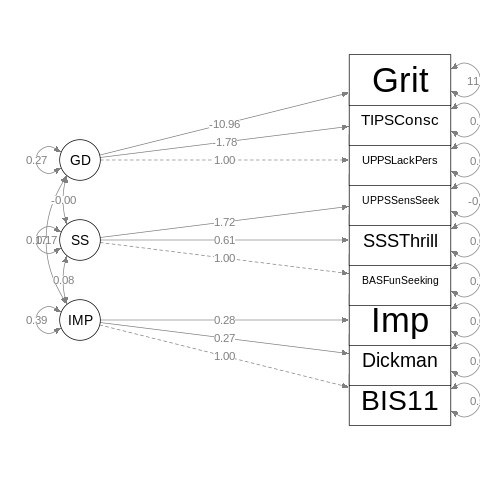

In [35]:
%%R

varnames = c('BIS11', 'Dickman', 'Imp', 'BASFunSeeking', 'SSSThrill', 'UPPSSensSeek', 'UPPSLackPers', 'TIPSConsc','Grit', "IMP" ,"SS",  "GD" )

semPaths(fit, "model", "est", 
         rotation=2, sizeMan =20, sizeMan2 = 10, 
         nodeLabels=varnames, edge.label.cex = 1)

## Model fit testing

blah blah blah

In [29]:
%%R

summary(fit, fit.measures=TRUE)

lavaan 0.6-5 ended normally after 51 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of free parameters                         21
                                                      
  Number of observations                           510
                                                      
Model Test User Model:
                                                      
  Test statistic                               348.645
  Degrees of freedom                                24
  P-value (Chi-square)                           0.000

Model Test Baseline Model:

  Test statistic                              2927.019
  Degrees of freedom                                36
  P-value                                        0.000

User Model versus Baseline Model:

  Comparative Fit Index (CFI)                    0.888
  Tucker-Lewis Index (TLI)                       0.832

Loglikelihood and Information Criteri

...


## Model comparison



In [30]:
%%R

# fit a simpler two-factor model
cfa.model2 <- 'IMP =~ bis11_survey.Nonplanning + dickman_survey.dysfunctional + impulsive_venture_survey.impulsiveness + upps_impulsivity_survey.lack_of_perseverance + ten_item_personality_survey.conscientiousness + grit_scale_survey.grit
              SS =~ bis_bas_survey.BAS_fun_seeking + sensation_seeking_survey.thrill_adventure_seeking + upps_impulsivity_survey.sensation_seeking '

fit2 <- cfa(cfa.model2, data=cfadata)

summary(fit2, fit.measures=TRUE)


lavaan 0.6-5 ended normally after 38 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of free parameters                         19
                                                      
  Number of observations                           510
                                                      
Model Test User Model:
                                                      
  Test statistic                               660.063
  Degrees of freedom                                26
  P-value (Chi-square)                           0.000

Model Test Baseline Model:

  Test statistic                              2927.019
  Degrees of freedom                                36
  P-value                                        0.000

User Model versus Baseline Model:

  Comparative Fit Index (CFI)                    0.781
  Tucker-Lewis Index (TLI)                       0.696

Loglikelihood and Information Criteri

In [31]:
%%R 

library(semTools)

compareFit(fit, fit2)

R[write to console]:  

R[write to console]: ###############################################################################

R[write to console]: This is semTools 0.5-2

R[write to console]: All users of R (or SEM) are invited to submit functions or ideas for functions.

R[write to console]: ###############################################################################



################### Nested Model Comparison #########################
Chi-Squared Difference Test

     Df    AIC    BIC  Chisq Chisq diff Df diff Pr(>Chisq)    
fit  24 6722.5 6811.4 348.65                                  
fit2 26 7029.9 7110.4 660.06     311.42       2  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

####################### Model Fit Indices ###########################
        chisq df pvalue   cfi   tli       aic       bic rmsea  srmr
fit  348.645† 24   .000 .888† .832† 6722.480† 6811.403† .163† .118†
fit2 660.063  26   .000 .781  .696  7029.898  7110.352  .219  .155 

################## Differences in Fit Indices #######################
           df    cfi    tli     aic     bic rmsea  srmr
fit2 - fit  2 -0.107 -0.135 307.418 298.949 0.056 0.037



## Cross-validation

We can also used cross-validation to assess the fit of a model to held-out data, using the same loss function that we used for fitting the model:


$$
F_{ML} = log |\Sigma(\theta)| + tr(\textbf{S}\Sigma^{-1}(\theta)) - log|\textbf{S}| - (p + q)
$$

To do this, let's create a python function that uses rpy2 to call lavaan:

In [32]:
pandas2ri.py2rpy(SRO_data[['Age']])
r('print(SRO_data)')

R[write to console]: Error in print(SRO_data) : object 'SRO_data' not found
Calls: <Anonymous> -> <Anonymous> -> print

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In lav_data_full(data = data, group = group, cluster = cluster,  :
R[write to console]: 
 
R[write to console]:  lavaan WARNING: some observed variances are (at least) a factor 1000 times larger than others; use varTable(fit) to investigate

R[write to console]: 2: 
R[write to console]: In lav_object_post_check(object) :
R[write to console]: 
 
R[write to console]:  lavaan WARNING: some estimated ov variances are negative

R[write to console]: 3: 
R[write to console]: In lav_data_full(data = data, group = group, cluster = cluster,  :
R[write to console]: 
 
R[write to console]:  lavaan WARNING: some observed variances are (at least) a factor 1000 times larger than others; use varTable(fit) to investigate

R[write to console]: 4: 
R[write to console]

RRuntimeError: Error in print(SRO_data) : object 'SRO_data' not found
Calls: <Anonymous> -> <Anonymous> -> print


In [ ]:
from rpy2.robjects.packages import importr
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

nruns = 10
test_proportion = .2

r('''
fml = function(observed, implied){
 log(det(observed)) - log(det(implied)) + sum(diag(solve(implied)%*%observed)) + length(diag(observed))
}''')

fml = r('''
library(lavaan)

cfa.model <- "IMP =~ bis11_survey.Nonplanning + dickman_survey.dysfunctional + impulsive_venture_survey.impulsiveness
              SS =~ bis_bas_survey.BAS_fun_seeking + sensation_seeking_survey.thrill_adventure_seeking + upps_impulsivity_survey.sensation_seeking
              GD =~ upps_impulsivity_survey.lack_of_perseverance + ten_item_personality_survey.conscientiousness + grit_scale_survey.grit"
cfa.model2 <- "IMP =~ bis11_survey.Nonplanning + dickman_survey.dysfunctional + impulsive_venture_survey.impulsiveness + upps_impulsivity_survey.lack_of_perseverance + ten_item_personality_survey.conscientiousness + grit_scale_survey.grit
              SS =~ bis_bas_survey.BAS_fun_seeking + sensation_seeking_survey.thrill_adventure_seeking + upps_impulsivity_survey.sensation_seeking "
cfa.model3 <- "SC =~ bis11_survey.Nonplanning + dickman_survey.dysfunctional + impulsive_venture_survey.impulsiveness + upps_impulsivity_survey.lack_of_perseverance + ten_item_personality_survey.conscientiousness + grit_scale_survey.grit + bis_bas_survey.BAS_fun_seeking + sensation_seeking_survey.thrill_adventure_seeking + upps_impulsivity_survey.sensation_seeking "

nruns = %d
testprop = %f
npts = nrow(cfadata)
idx = rep(0, npts)
idx[1:round(npts*testprop)] = 1
fmlresult = c()

for (i in 1:nruns){
    # split train/test
    idx = sample(idx)
    traindata = cfadata[idx==0,]
    testdata = cfadata[idx==1,]
    fit = cfa(cfa.model, data=traindata)
    fit2 = cfa(cfa.model2, data=traindata)
    fit3 = cfa(cfa.model3, data=traindata)


    test_cov = cov(testdata)
    train_cov = cov(traindata)
    implied_cov = fitted(fit)$cov
    fmlresult = rbind(fmlresult, c(fml(train_cov, fitted(fit)$cov), fml(train_cov, fitted(fit2)$cov), fml(train_cov, fitted(fit3)$cov),
            fml(test_cov, fitted(fit)$cov), fml(test_cov, fitted(fit2)$cov), fml(test_cov, fitted(fit3)$cov)))

}
''' % (nruns, test_proportion))


In [ ]:
%%R


apply(fmlresult, 2, mean)

In [ ]:
foo = r['data.frame'](cfadata)
foo

In [ ]:
r('dim(cfadata)')

In [ ]:
%%R

ls()

In [ ]:
newdata = cfadata.copy()
foo = r['data.frame'](newdata)
